In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

import numpy.random as rnd
from matplotlib.patches import Ellipse

In [2]:
import scipy.io as io
import h5py
from numpy.fft import fft2, ifft2, ifftshift

C:\Users\jihuijin\Anaconda3\envs\pytorch\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import scipy.io as io
from skimage.transform import resize

## Random Ellipse Generation

In [4]:
def inEllipse(x,y,x0=0,y0=0,a=1,b=1,th=0):
    return ((((x-x0)*np.cos(th))+(y-y0)*np.sin(th))/a)**2 \
           + ((((x-x0)*np.sin(th))-(y-y0)*np.cos(th))/b)**2  <= 1
def genEllipseImg(H,W,num=0):
    if not num:
        num = rnd.randint(10,25)
    img = np.zeros((H,W))
    
    # Note: due to python indexing, x is treated as vertical
    x = np.arange(H)
    y = np.arange(W)[:,None]
    
    axlower = int(np.minimum(H,W)/32)
    axupper = int(np.minimum(H,W)/8)
    for i in range(num):
        # generate center
        x0 = rnd.randint(int(.1*H),int(.9*H))
        y0 = rnd.randint(int(.1*W),int(.9*W))
        
        # generate major/minor axes
        a,b = rnd.randint(axlower,axupper,2)
        
        # generate random angle between 0 to pi
        th = rnd.rand()*np.pi
        
        # generate random value between -.7 to .7
        mag = 1.4*rnd.rand()-.7
        
        img[inEllipse(x,y,x0,y0,a,b,th)] += mag
    # clip images
    img[img>1]=1
    img[img<-1]=-1
    return img
    

## Fourier Line Sampling

In [5]:
def LineMask(L,N):
    # port of code writter by Justin Romberg 
    #for line sampling in 2D fourier space
    thc = np.linspace(0,np.pi-np.pi/L,L)
    M = np.zeros((N,N))
    for th in thc:
        if ((th <= np.pi/4) or (th > 3*np.pi/4)):
            yr = np.round(np.tan(th)*(np.arange(-N/2+1,N/2)))+N/2
            yr = yr.astype(int)
            for i,y in enumerate(yr,1):
                M[y,i] = 1
        else:
            xc = np.round((1/np.tan(th))*(np.arange(-N/2+1,N/2)))+N/2
            xc = xc.astype(int)
            for i,x in enumerate(xc,1):
                M[i,x] = 1
    M = ifftshift(M)
    M[0,0] = 1
    return M
def RandomLineMask(L,N):
    # port of code writter by Justin Romberg 
    #for line sampling in 2D fourier space
    #thc = np.linspace(0,np.pi-np.pi/L,L)
    thc = np.random.random(L)
    thc[0] = 0
    thc = np.cumsum(thc)
    thc = thc/thc[-1]*(np.pi-np.pi/L)
    
    M = np.zeros((N,N))
    for th in thc:
        if ((th <= np.pi/4) or (th > 3*np.pi/4)):
            yr = np.round(np.tan(th)*(np.arange(-N/2+1,N/2)))+N/2
            yr = yr.astype(int)
            for i,y in enumerate(yr,1):
                M[y,i] = 1
        else:
            xc = np.round((1/np.tan(th))*(np.arange(-N/2+1,N/2)))+N/2
            xc = xc.astype(int)
            for i,x in enumerate(xc,1):
                M[i,x] = 1
    M = ifftshift(M)
    M[0,0] = 1
    return M
def fftsample(x,mask):
    xdft = fft2(x)
    y = xdft[mask]
    return y
def ifftsample(y,mask):
    x = np.zeros(mask.shape).astype(np.complex128)
    x[mask] = y
    return np.real(ifft2(x))


(20,)


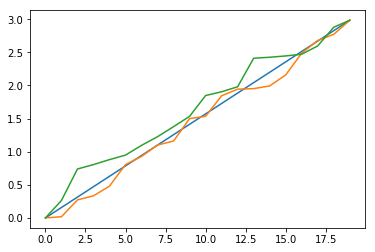

In [18]:
L=20
thc = np.linspace(0,np.pi-np.pi/L,L)
temp = np.random.random(L-1)
temp = np.concatenate([[0],temp])
temp = np.cumsum(temp)

temp2 = np.random.random(L-2)*(np.pi-np.pi/L)
temp2 = np.concatenate([[0],temp2,[np.pi-np.pi/L]])
print(temp2.shape)
temp2.sort()
plt.plot(thc)
plt.plot(temp*(np.pi-np.pi/L)/temp[-1])
plt.plot(temp2)

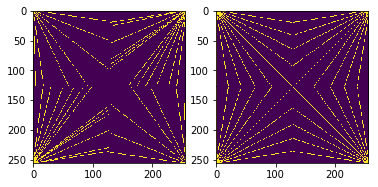

In [21]:
mask = RandomLineMask(20,256)
plt.subplot(121)
plt.imshow(mask)
plt.subplot(122)
plt.imshow(LineMask(20,256))

# Generate Synthetic Dataset

In [6]:
filename = 'RandomLineEllipses15.hdf5'

In [7]:
numimages = 4600

In [9]:
trainlabels = np.array([genEllipseImg(256,256) for _ in range(numimages)])

In [10]:
#mask = LineMask(10,256) == 1
traindata = np.zeros(trainlabels.shape)

mses = np.zeros(len(trainlabels))
for i,trainlabel in enumerate(trainlabels):
    mask = RandomLineMask(15,256) == 1
    y = fftsample(trainlabel,mask)
    xhat = ifftsample(y,mask)
    traindata[i,:,:] = xhat
    mses[i]=np.mean((xhat-trainlabel)**2)

    
#     plt.figure()
#     plt.subplot(121)
#     plt.imshow(trainlabel)
#     plt.subplot(122)
#     plt.imshow(traindata[i,:,:])


In [11]:
trainlabels.shape

(4600, 256, 256)

0.011151900392326301


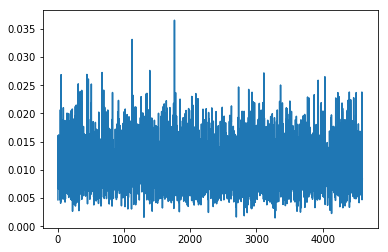

In [12]:
plt.plot(mses)
print(mses.mean())

In [13]:
f = h5py.File(filename,'a')
dset_data = f.create_dataset('synthetic/training_data', data=traindata, compression='gzip')
dset_gt = f.create_dataset('synthetic/training_labels', data=trainlabels, compression='gzip')
f.close()
del traindata, trainlabels

# Generate from existing dataset

In [15]:
mat = io.loadmat('../data/preproc_x20_ellipse_fullfbp.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'dsr', 'lab_d', 'lab_n'])

In [17]:
#lab_d = mat['lab_d']
lab_n = mat['lab_n']
del mat
lab_n.shape

num = lab_n.shape[-1]
ellip_labels = np.zeros((num,256,256))

for i in range(num):
    img = resize(lab_n[:,:,0,i],(256,256),preserve_range=True)
    img /= 400
    ellip_labels[i] = img
del lab_n

C:\Users\jihuijin\Anaconda3\envs\pytorch\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [20]:
ellip_masked = np.zeros(ellip_labels.shape)
ellip_clean = np.zeros(ellip_labels.shape)

sigma = 40
ellip_mses = np.zeros(num)
clean_mses = np.zeros(num)
for i in range(num):
    img = ellip_labels[i]
    mask = RandomLineMask(15,256) == 1
    y = fftsample(img,mask)
    xclean = ifftsample(y,mask)
    clean_mses = np.mean((xclean-img)**2)
    ellip_clean[i] = xclean
    
    y += np.random.normal(0,sigma,y.shape)
    xhat = ifftsample(y,mask)
    ellip_masked[i] = xhat
    ellip_mses[i] = np.mean((xhat-img)**2)
    
#del lab_n
print(ellip_mses.mean(),clean_mses.mean())

0.0028766400649248166 0.0029673830595842486


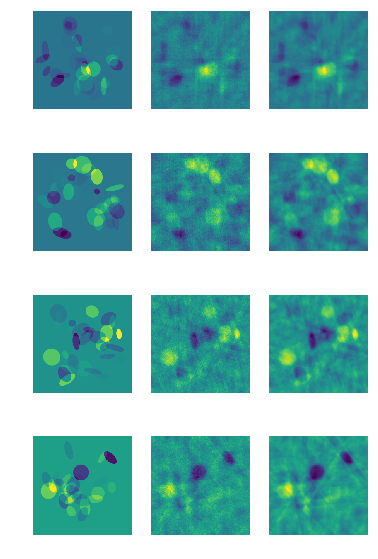

In [21]:
plt.figure(figsize=(6,10))
for i in range(4):
    plt.subplot(4,3,3*i+1)
    plt.imshow(ellip_labels[i])
    plt.axis('off')
    plt.subplot(4,3,3*i+2)
    plt.imshow(ellip_masked[i])
    plt.axis('off')
    plt.subplot(4,3,3*i+3)
    plt.imshow(ellip_clean[i])
    plt.axis('off')

In [22]:
f = h5py.File(filename,'a')
dset_data = f.create_dataset('ellip/training_data', data=ellip_masked[:400], compression='gzip')
dset_gt = f.create_dataset('ellip/training_labels', data=ellip_labels[:400], compression='gzip')
dset_test = f.create_dataset('ellip/test_data', data=ellip_masked[400:], compression='gzip')
dset_testgt = f.create_dataset('ellip/test_labels', data=ellip_labels[400:], compression='gzip')
f.close()
#del ellip_masked, ellip_labels, ellip_clean

In [24]:
f = h5py.File(filename,'a')
print(list(f.keys()))
f.close()

['ellip', 'synthetic']


In [25]:
f = h5py.File('PreProcessedEllipses256.hdf5','a')
dset = f.create_dataset('ellipses',data=ellip_labels,compression='gzip')
f.close()